## 1. SETUP AND LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import joblib
import warnings
import seaborn as sns
warnings.filterwarnings('ignore', category=UserWarning) # To hide some joblib warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. DATA LOADING AND FEATURE ENGINEERING

In [3]:
df = pd.read_csv('bts_power_dataset(in).csv')

print("Dataset Head:")
print(df.head())

Dataset Head:
     BTS_ID Power_Source Site_Category Network_Technology  \
0  BTS_0001         Grid         Rural                 3G   
1  BTS_0002        Solar         Rural                 4G   
2  BTS_0003         Grid         Urban                 4G   
3  BTS_0004        Solar         Rural                 4G   
4  BTS_0005        Solar         Urban                 4G   

   Power_Consumption_Jan  Power_Consumption_Feb  Power_Consumption_Mar  \
0                    603                    615                    608   
1                    982                   1011                    970   
2                   1635                   1649                   1636   
3                   1083                   1079                   1075   
4                   1418                   1374                   1419   

   Power_Consumption_Apr  Power_Consumption_May  Power_Consumption_Jun  \
0                    628                    667                    673   
1                    977  

### Check for missing values

In [4]:
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
BTS_ID                   0
Power_Source             0
Site_Category            0
Network_Technology       0
Power_Consumption_Jan    0
Power_Consumption_Feb    0
Power_Consumption_Mar    0
Power_Consumption_Apr    0
Power_Consumption_May    0
Power_Consumption_Jun    0
Downlink                 0
Uplink                   0
dtype: int64


There is no missing values , so no need of data preprocessing ...

### Feature Engineering

In [5]:
df['Avg_Power_Consumption'] = df[['Power_Consumption_Jan', 'Power_Consumption_Feb', 'Power_Consumption_Mar', 'Power_Consumption_Apr', 'Power_Consumption_May', 'Power_Consumption_Jun']].mean(axis=1)
df['Total_Traffic'] = df['Downlink'] + df['Uplink']

features = ['Power_Source', 'Site_Category', 'Network_Technology', 'Total_Traffic']
target = 'Avg_Power_Consumption'

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data loaded and prepared.")

Data loaded and prepared.


### Exploratory Data Analysis (EDA)

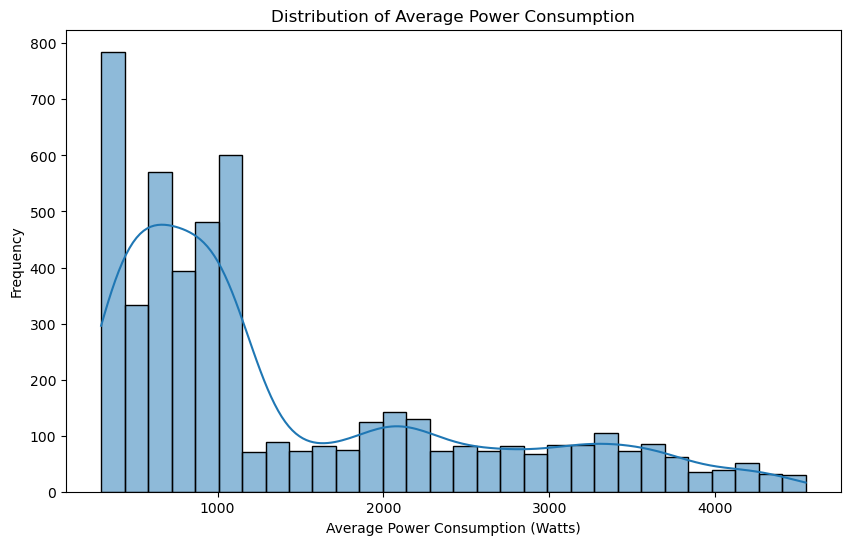

In [6]:
# 1. Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Avg_Power_Consumption'], kde=True, bins=30)
plt.title('Distribution of Average Power Consumption')
plt.xlabel('Average Power Consumption (Watts)')
plt.ylabel('Frequency')
plt.show()

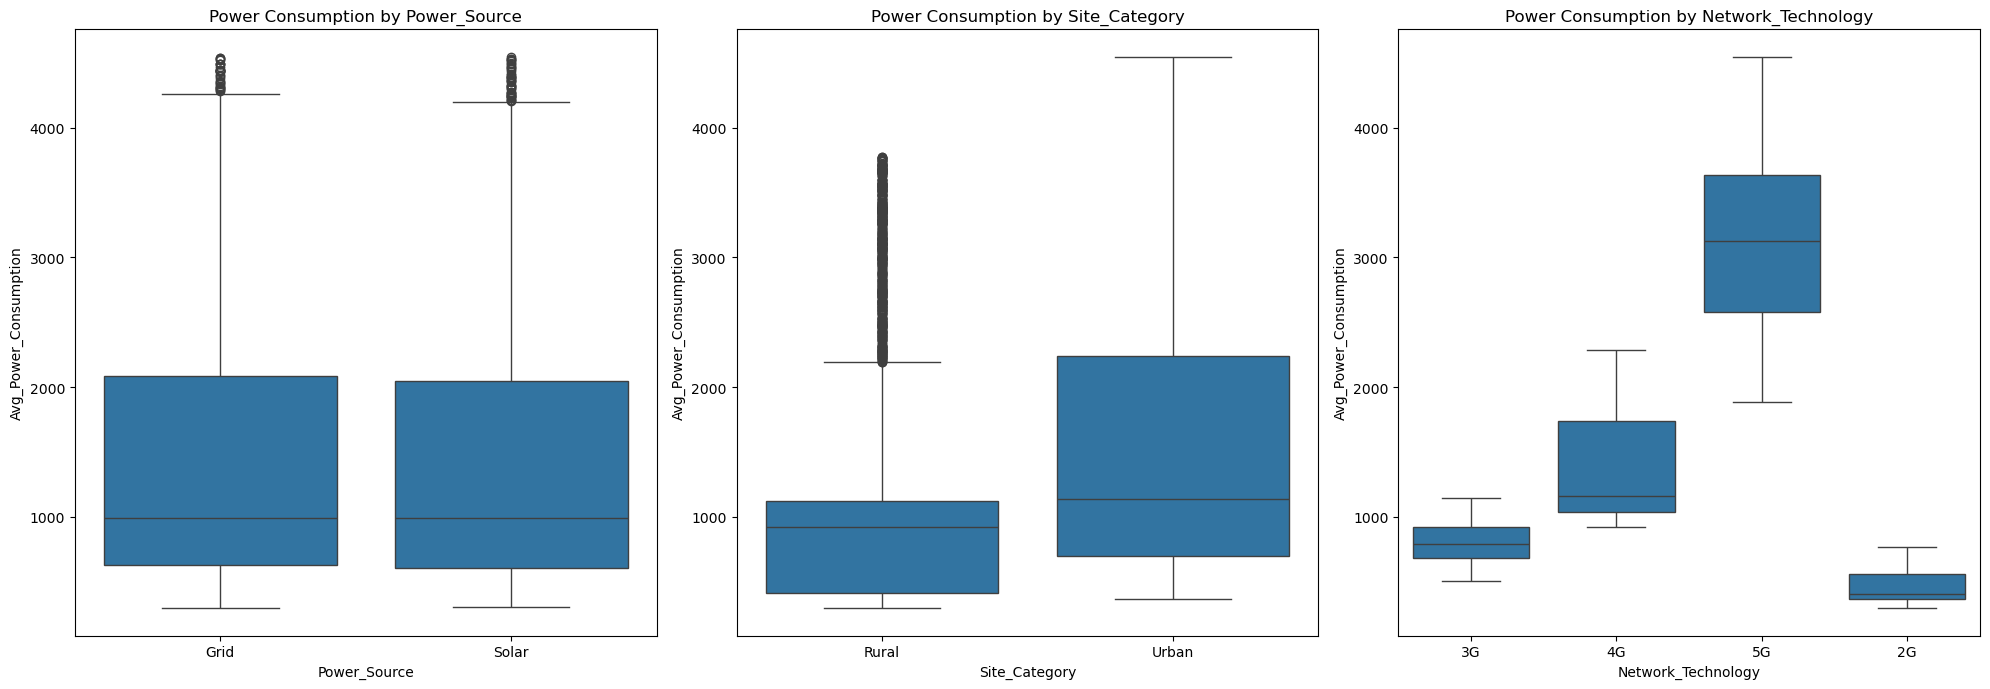

In [7]:
# 2. Relationship between categorical features and power consumption
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
categorical_features = ['Power_Source', 'Site_Category', 'Network_Technology']

for i, feature in enumerate(categorical_features):
    sns.boxplot(ax=axes[i], x=feature, y='Avg_Power_Consumption', data=df)
    axes[i].set_title(f'Power Consumption by {feature}')

plt.tight_layout()
plt.show()

## 3. ROBUST PIPELINE CREATION

In [8]:
categorical_features = ['Power_Source', 'Site_Category', 'Network_Technology']
numerical_features = ['Total_Traffic']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features) # Explicitly pass through numerical features
    ])

# We create a pipeline with a placeholder for the regressor
# This allows GridSearchCV to swap different models in and out
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42)) # Placeholder
])

print("Robust Machine Learning Pipeline created.")

Robust Machine Learning Pipeline created.


## 4. MULTI-MODEL HYPERPARAMETER TUNING

In [9]:
# This is the major enhancement. We create a list of parameter grids.
# Each dictionary in the list defines a different model and its specific parameters to test. GridSearchCV will try all of them.
# =============================================================================

param_grid = [
    # Dictionary for RandomForestRegressor
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [100, 150],
        'regressor__max_depth': [10, 20, None]
    },
    # Dictionary for GradientBoostingRegressor
    {
        'regressor': [GradientBoostingRegressor(random_state=42)],
        'regressor__n_estimators': [100, 150],
        'regressor__learning_rate': [0.05, 0.1]
    },
    # Dictionary for LinearRegression (no hyperparameters to tune)
    {
        'regressor': [LinearRegression()]
    }
]


# Create and run the Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

print("Starting multi-model hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# This is now the champion model (best algorithm with its best settings)
best_model = grid_search.best_estimator_

print("\n--- Grid Search Complete ---")
print(f"The best model is: {grid_search.best_params_['regressor'].__class__.__name__}")
print(f"Best Model Parameters: {grid_search.best_params_}")


Starting multi-model hyperparameter tuning...

--- Grid Search Complete ---
The best model is: GradientBoostingRegressor
Best Model Parameters: {'regressor': GradientBoostingRegressor(random_state=42), 'regressor__learning_rate': 0.05, 'regressor__n_estimators': 150}


## 5. MODEL EVALUATION

In [10]:
print("\n--- Model Evaluation ---")
y_pred = best_model.predict(X_test)

# --- Standard Metrics ---
# R-squared: Measures how well the model explains the variance in the data. Closer to 1 is better.
r2 = r2_score(y_test, y_pred)

# Mean Absolute Error (MAE): The average absolute difference between predicted and actual values.
mae = mean_absolute_error(y_test, y_pred)

# Root Mean Squared Error (RMSE): Similar to MAE but penalizes larger errors more heavily.
# We calculate it by taking the square root of the mean_squared_error.
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


# --- Custom Accuracy Score ---
# We define a prediction as "accurate" if it is within 10% of the actual value.
tolerance = 0.10
accurate_predictions = np.sum(np.abs(y_pred - y_test) <= tolerance * y_test)
custom_accuracy = (accurate_predictions / len(y_test)) * 100


# --- Print All Results ---
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} Watts")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} Watts")
print(f"Custom Accuracy (+/- {tolerance*100}%): {custom_accuracy:.2f}%")



--- Model Evaluation ---
R-squared (R²): 0.9892
Mean Absolute Error (MAE): 78.83 Watts
Root Mean Squared Error (RMSE): 115.99 Watts
Custom Accuracy (+/- 10.0%): 83.70%


## 5A. ERROR ANALYSIS


--- Error Analysis ---


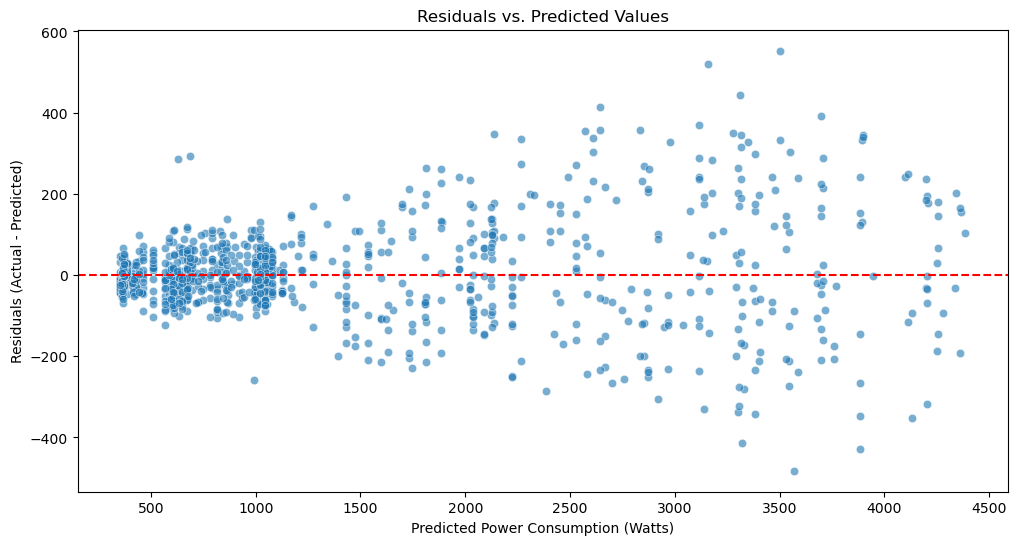

In [13]:
# =============================================================================
# This is the missing piece. We analyze the model's errors (residuals) to
# understand *where* and *why* it is making mistakes. This is crucial for
# suggesting future improvements.
# =============================================================================
print("\n--- Error Analysis ---")

# Calculate the residuals (the difference between actual and predicted values)
residuals = y_test - y_pred

# Create a results DataFrame for easier plotting
results_df = X_test.copy()
results_df['Actual_Consumption'] = y_test
results_df['Predicted_Consumption'] = y_pred
results_df['Residuals'] = residuals

# --- Plot 1: Residuals vs. Predicted Values ---
# This plot helps us check for patterns in the errors.
# Ideally, we want to see a random cloud of points centered around zero.
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Predicted_Consumption', y='Residuals', data=results_df, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--') # Add a horizontal line at y=0
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Power Consumption (Watts)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()


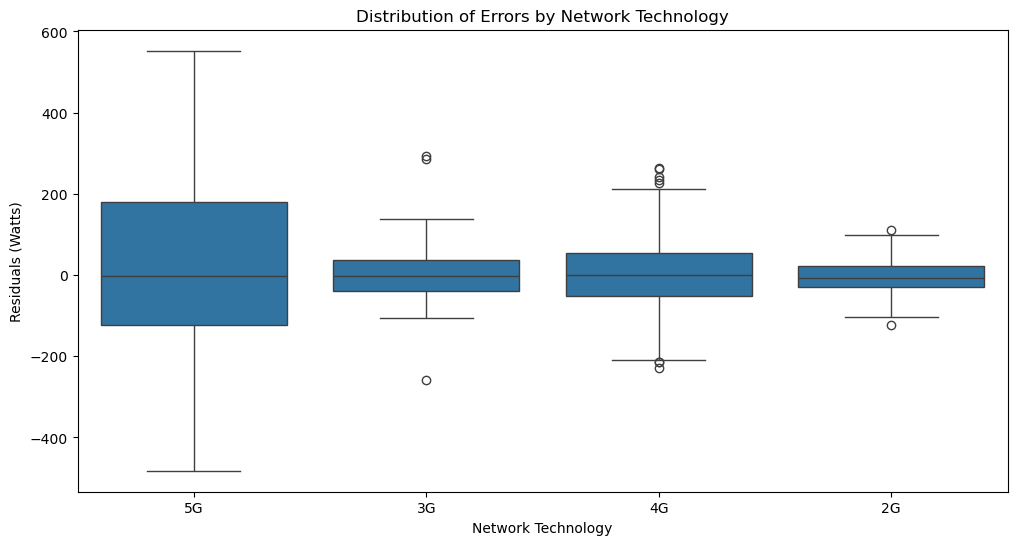

In [14]:
# --- Plot 2: Residuals by Network Technology ---
# This plot helps us see if the model struggles with a specific category.
plt.figure(figsize=(12, 6))
sns.boxplot(x='Network_Technology', y='Residuals', data=results_df)
plt.title('Distribution of Errors by Network Technology')
plt.xlabel('Network Technology')
plt.ylabel('Residuals (Watts)')
plt.show()

## 6. SAVE AND USE THE MODEL

In [15]:
model_filename = 'bts_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\nChampion model saved to '{model_filename}'")


Champion model saved to 'bts_model.joblib'


## 7. Prediction on New Data

In [17]:
# =============================================================================
# 8. DYNAMIC PREDICTION (Accepting Separate Downlink/Uplink)
# =============================================================================
print("\n--- Dynamic Prediction with Saved Model ---")

# Define the model filename
model_filename = 'bts_model.joblib'

# Load the model from the file
try:
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully from file.")

    # --- Get User Input ---
    print("\nEnter New BTS Details for Prediction:")
    
    # Create a dictionary to hold the user's input
    input_data = {}

    # Get categorical inputs
    input_data['Power_Source'] = input("Enter Power Source (Grid/Solar): ").strip().title()
    input_data['Site_Category'] = input("Enter Site Category (Urban/Rural): ").strip().title()
    input_data['Network_Technology'] = input("Enter Network Technology (2G/3G/4G/5G): ").strip().upper()

    # Get Downlink and Uplink inputs separately with validation
    while True:
        try:
            input_data['Downlink'] = float(input("Enter Downlink traffic: "))
            break
        except ValueError:
            print("Invalid input. Please enter a number for Downlink traffic.")
            
    while True:
        try:
            input_data['Uplink'] = float(input("Enter Uplink traffic: "))
            break
        except ValueError:
            print("Invalid input. Please enter a number for Uplink traffic.")

    # Create a DataFrame from the input dictionary
    input_df = pd.DataFrame([input_data])
    
    # --- PREDICTION STEP ---
    # The pipeline requires the 'Total_Traffic' feature, so we create it here.
    input_df['Total_Traffic'] = input_df['Downlink'] + input_df['Uplink']
    
    print("\nInput data for prediction (Total_Traffic is calculated automatically):")
    print(input_df[['Power_Source', 'Site_Category', 'Network_Technology', 'Total_Traffic']])

    # Make the prediction
    # The loaded pipeline will automatically select the columns it needs ('Total_Traffic', etc.)
    # and ignore the extra 'Downlink' and 'Uplink' columns.
    predicted_power = loaded_model.predict(input_df)

    print()
    print("\n---------------------------------------------------")
    print(f"Predicted Average Power Consumption: {predicted_power[0]:.2f} Watts")
    print("---------------------------------------------------")

# Handle cases where the model file doesn't exist yet
except FileNotFoundError:
    print(f"Error: Model file '{model_filename}' not found. Please run the training and saving steps first.")
except Exception as e:
    print(f"An error occurred during prediction: {e}")


--- Dynamic Prediction with Saved Model ---
Model loaded successfully from file.

Enter New BTS Details for Prediction:


Enter Power Source (Grid/Solar):  Solar
Enter Site Category (Urban/Rural):  Rural
Enter Network Technology (2G/3G/4G/5G):  4G
Enter Downlink traffic:  93.05
Enter Uplink traffic:  44.85



Input data for prediction (Total_Traffic is calculated automatically):
  Power_Source Site_Category Network_Technology  Total_Traffic
0        Solar         Rural                 4G          137.9


---------------------------------------------------
Predicted Average Power Consumption: 1019.93 Watts
---------------------------------------------------
